### Environment Setup and API Configuration

This cell loads environment variables and configures the API keys required for the LLM and external tools.

We use:
- GROQ_API_KEY for accessing the Groq-hosted LLM
- TAVILY_API_KEY for enabling web search through Tavily

This ensures secure authentication without hardcoding credentials.


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

### Initializing Tools and the Language Model

In this cell, we initialize the external tools and the language model:

- TavilySearchResults for real-time web search  
- ArxivQueryRun for querying research papers from Arxiv  
- ChatGroq as the primary LLM  

These tools will later be bound to the agent so it can decide when to use them dynamically.


In [2]:
from langchain_community.tools import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun
from langchain_groq import ChatGroq
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

tavily_search=TavilySearchResults(max_results=2)

llm=ChatGroq(model="qwen/qwen3-32b")

tools = [arxiv,tavily_search]

C:\Users\mouli\AppData\Local\Temp\ipykernel_54748\2536606333.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search=TavilySearchResults(max_results=2)


### Sanity Check: Testing the Base LLM

This cell performs a simple invocation of the language model to verify that:
- The API key is correctly configured  
- The model is responding as expected  

This helps confirm that the LLM setup is working before adding tools and agent logic.


In [3]:
llm.invoke("hi")

AIMessage(content='<think>\nOkay, the user just said "hi". I need to respond appropriately. Since this is the start of a conversation, I should be friendly and open. Let me greet them back and offer assistance. Maybe ask how I can help them today. Keep it simple and welcoming. Make sure to use an emoji to keep the tone light. Alright, that should work.\n</think>\n\nHi there! 😊 How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 9, 'total_tokens': 99, 'completion_time': 0.164739415, 'prompt_time': 0.000233256, 'queue_time': 0.093224157, 'total_time': 0.164972671}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--f7030170-7208-456c-912a-1911e80ae5ab-0', usage_metadata={'input_tokens': 9, 'output_tokens': 90, 'total_tokens': 99})

### Binding Tools to the Language Model

Here we bind the available tools to the LLM.

This enables the model to:
- Decide when a tool is needed  
- Generate structured tool calls  
- Request execution of external tools  

After this step, the model becomes tool-aware and capable of calling Arxiv or Tavily dynamically.


In [4]:
llm_with_tools=llm.bind_tools(tools)
llm_with_tools.invoke("What is attention all you need")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about "attention all you need." Hmm, I think this refers to the attention mechanism in deep learning, specifically from the transformer model. The paper "Attention Is All You Need" introduced the transformer architecture, which uses self-attention mechanisms. Let me confirm.\n\nFirst, I should check if this is a known paper on arXiv. The user might be looking for an explanation of the concept or details about the paper. Since the question is about a specific paper, using the arXiv function would be best to get accurate information. \n\nWait, the user might not know the exact title. Let me make sure. The correct title is "Attention Is All You Need," published in 2017. The authors are Vaswani et al. The arXiv function can retrieve this paper. So I should call the arXiv function with the query "Attention Is All You Need" to get the paper\'s details. That should provide the necessary information for the

### Defining the Agent State Schema

This cell defines the shared state structure used by LangGraph.

The state contains:
- A list of messages representing the conversation history  

The `add_messages` reducer automatically appends new messages to the state as the workflow progresses.


In [5]:
from typing import Annotated,TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

### Agent Node: Reasoning and Tool Selection

This function represents the main agent node.

It sends the current conversation state to the tool-enabled LLM and lets the model decide:
- Whether to answer directly  
- Or whether to call an external tool  

The result is appended back into the message state.


In [6]:
def agent(state:GraphState):
    """  
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply use the llm 
    knowledge to answer the user question.

    """
    response = llm_with_tools.invoke(state["messages"]) 
    return {"messages": [response]}

### Final Response Node

This node is responsible for generating the final answer after tool execution.

It receives the updated conversation state (including tool outputs) and produces the final user-facing response using the base LLM.


In [7]:
def llm_response(state:GraphState):
    """  
    Generates response based on the tool call

    """
    response = llm.invoke(state["messages"]) 
    return {"messages": [response]}

### Testing the Agent Node Independently

This cell directly invokes the agent function with a sample user query.

It helps inspect:
- Whether the agent produces a normal response  
- Or generates tool calls  

The output is pretty-printed for easier debugging and inspection.


In [8]:
agent({"messages":[{"role":"user","content":"what are types of agentic ai?"}]})["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  arxiv (sbrczasz8)
 Call ID: sbrczasz8
  Args:
    query: types of agentic AI


### Routing Logic for Tool Invocation

This function inspects the last message produced by the agent.

If the message contains tool calls:
- The workflow is routed to the tool execution node  

If no tool call is present:
- The workflow terminates  

This enables conditional execution based on the agent’s decision.


In [ ]:
def route(state: GraphState):
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"   
    return "END"

### Building the LangGraph Workflow

This cell constructs the full agent workflow using LangGraph.

Nodes:
- agent_response: main reasoning and tool selection node  
- tools: executes selected tools  
- llm_response: generates the final response  

Edges:
- Start → Agent  
- Agent → Tools (if tool call exists)  
- Agent → End (if no tool needed)  
- Tools → Final LLM response  

This creates a controlled, deterministic tool-calling agent pipeline.


In [ ]:
from langgraph.graph import StateGraph,START,END

graph=StateGraph(GraphState)
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([arxiv, tavily_search])

graph.add_node("agent_response", agent)
graph.add_node("tools", tool_node)
graph.add_node("llm_response",llm_response)
graph.add_edge(START, "agent_response")
graph.add_conditional_edges("agent_response", route, 
    {"tools": "tools", "END": END}
)

graph.add_edge("tools", "llm_response")

graph_builder = graph.compile()

### Visualizing the Agent Workflow

This cell renders the internal LangGraph workflow as a diagram.

It helps visualize:
- Execution flow  
- Conditional branching  
- Tool integration points  

This is extremely useful for debugging and understanding agent control flow.


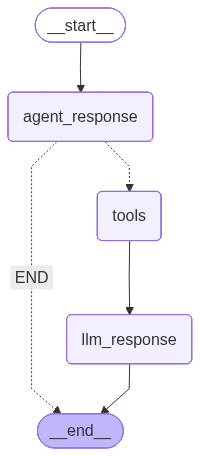

In [11]:
from IPython.display import Image, display
display(Image(graph_builder.get_graph(xray=True).draw_mermaid_png()))

### Running the Tool Calling Agent – Example 1

This cell runs the compiled agent graph with a sample query.

The agent may:
- Answer directly using the LLM  
- Or invoke a tool if external information is required  

The final response is returned from the workflow.


In [15]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "what is machine learning?",
        }
    ]
}
response=graph_builder.invoke(input)
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

what is machine learning?
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that focuses on developing algorithms and statistical models that enable computers to perform tasks by learning patterns from data, rather than relying on explicit programming. It involves training models on datasets to make predictions, decisions, or identify patterns. Key types include:

1. **Supervised Learning**: Uses labeled data to predict outcomes (e.g., classification, regression).
2. **Unsupervised Learning**: Finds hidden patterns in unlabeled data (e.g., clustering).
3. **Reinforcement Learning**: Learns by interacting with an environment to maximize rewards.

Applications range from recommendation systems and image recognition to natural language processing and autonomous vehicles. The field combines concepts from computer scie

### Running the Tool Calling Agent – Example 2

This cell runs another example query through the agent.

It demonstrates how the same workflow dynamically adapts:
- Sometimes answering directly  
- Sometimes invoking tools  

This shows the flexibility of tool calling agents in real applications.


In [14]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "what is agentic ai?",
        }
    ]
}
response=graph_builder.invoke(input)
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

what is agentic ai?
================================== Ai Message ==================================
Tool Calls:
  arxiv (gyzy9stva)
 Call ID: gyzy9stva
  Args:
    query: agentic AI
================================= Tool Message =================================
Name: arxiv

Published: 2025-11-20
Title: Trustworthy AI in the Agentic Lakehouse: from Concurrency to Governance
Authors: Jacopo Tagliabue, Federico Bianchi, Ciro Greco
Summary: Even as AI capabilities improve, most enterprises do not consider agents trustworthy enough to work on production data. In this paper,
================================== Ai Message ==================================

<think>
Okay, the user asked about agentic AI. Let me start by recalling what I know. Agentic AI refers to AI systems that can act autonomously, right? They make decisions and take actions without constant human input. But I need to make sure I'm accurate.

